In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch import optim
from torch.utils.data import DataLoader

In [3]:
datapath="../datasets/fashion_mnist/"

In [4]:
n_epochs = 10
learning_rate = 0.01
batch_size = 64

In [5]:
def dataset_labels(i):
    return ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"][i]

In [6]:
training_set = datasets.FashionMNIST(root=datapath, download=False, train=True, transform=transforms.ToTensor())
test_set = datasets.FashionMNIST(root=datapath, download=False, train=False, transform=transforms.ToTensor())

training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

n_training_samples, img_width, img_height = training_set.train_data.shape

#### Plot to check how images look like

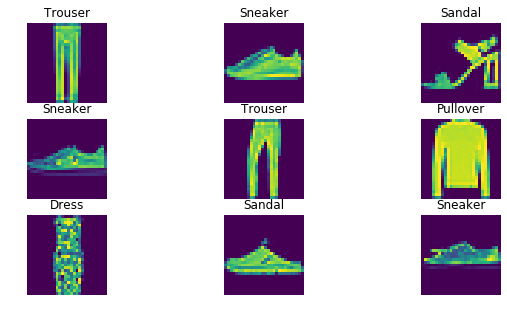

In [7]:
rand_idxs = np.random.randint(n_training_samples, size=9)
f, a = plt.subplots(nrows=3, ncols=3, figsize=(10, 5))

for i in range(9):
    X = training_set.train_data[rand_idxs[i]]
    Y = training_set.train_labels[rand_idxs[i]]
    
    r, c = i //3, i%3
    a[r][c].set_title(dataset_labels(Y))
    a[r][c].axis("off")
    a[r][c].imshow(X.numpy())
    
plt.draw()

### Simple CNN model for Fashion MNIST dataset

#### Use GPU if available

In [8]:
use_gpu=False
if torch.cuda.is_available():
    use_gpu=True

### Dimensions of the image after convolution and pooling
We use the formulae:
1. For Convolution:
$$\begin{align}
W_{out} = \dfrac{(W_{in} - F + 2P)}{S} + 1 \newline
H_{out} = \dfrac{(H_{in} - F + 2P)}{S} + 1 \newline
\end{align}$$

For Pooling:
    $$\begin{align}
    W_{out} = \dfrac{W_{in} - F}{S} + 1 \newline
    H_{out} = \dfrac{H_{in} - F}{S} + 1 \newline
    \end{align}$$
    
    where we assume the filter is square shaped  and the dilation etc are set to default values.

In [22]:
class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.convlayer1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.convlayer2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.poollayer1 = nn.MaxPool2d(kernel_size=2)
        self.convlayer3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3)
        self.ReLU = nn.ReLU()
        
        self.fc1 = nn.Linear( 30*4*4, 20) # 4*4 is the shape of the final image
        self.fc2 = nn.Linear(20, 10)
        
        
    def forward(self, x):
        x = self.ReLU(self.convlayer1(x))
        x = self.ReLU(self.convlayer2(x))
        x = self.poollayer1(x)
        x = self.ReLU(self.convlayer3(x))
        x = self.poollayer1(x)
        x = x.view(-1, 30*4*4)
        x = self.ReLU( self.fc1(x))
        x = self.fc2(x)
        
        return x
    
        
        
print(simpleCNN())

simpleCNN(
  (convlayer1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (convlayer2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (poollayer1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convlayer3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (ReLU): ReLU()
  (fc1): Linear(in_features=480, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)


### Initialize the CNN, Loss criterion, and optimizer

In [33]:
fmnistCNN = simpleCNN()
if use_gpu:
    #fmnistCNN = fmnistCNN.cuda()
    fmnistCNN.cuda()
lossfn = nn.CrossEntropyLoss() #Cross Entropy loss since this is a classification problem
#optimizer = optim.Adam(fmnistCNN.parameters() , lr=learning_rate)
optimizer = optim.Adam(fmnistCNN.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

In [38]:
curr_iter=0
for epoch in range(n_epochs*2):
    #print("Current epoch : {0}".format(epoch+1))
    #print("--" * 10)
    curr_loss = 0.0
    
    for (images, labels) in training_loader:
        images = images.cuda()
        labels = labels.cuda()
        images = Variable(images)
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = fmnistCNN(images)
        
        loss = lossfn(outputs, labels)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        curr_iter += 1
        curr_loss += loss.item()
        
        if curr_iter%1000 == 0:
            print("Current epoch {}: Training loss {:.3f}".format(epoch+1, curr_loss/1000))
            #print("For iteration number {0}, loss is: {1}".format(curr_iter, loss))
            #print("Training loss: %.3f \n" %(curr_loss/1000))
            curr_loss = 0.0
            
print("--"*20)
print("Finished Training")

Current epoch 2: Training loss 0.021
Current epoch 3: Training loss 0.041
Current epoch 4: Training loss 0.064
Current epoch 5: Training loss 0.085
Current epoch 6: Training loss 0.106
Current epoch 7: Training loss 0.126
Current epoch 8: Training loss 0.147
Current epoch 9: Training loss 0.170
Current epoch 10: Training loss 0.190
Current epoch 11: Training loss 0.209
Current epoch 12: Training loss 0.231
Current epoch 13: Training loss 0.252
Current epoch 14: Training loss 0.272
Current epoch 15: Training loss 0.296
Current epoch 16: Training loss 0.316
Current epoch 18: Training loss 0.019
Current epoch 19: Training loss 0.040
Current epoch 20: Training loss 0.061
----------------------------------------
Finished Training


#### Use model.eval() for testing/inference

In [39]:
fmnistCNN.eval()

simpleCNN(
  (convlayer1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (convlayer2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (poollayer1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convlayer3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (ReLU): ReLU()
  (fc1): Linear(in_features=480, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)

In [40]:
correct = 0
total = 0

In [41]:
for imgs, labels in test_loader:
    imgs = imgs.cuda()
    imgs = Variable(imgs)
    
    labels = labels.cuda()
    #labels = Variable(labels)
    preds = fmnistCNN(imgs)
    
    _,predicted = torch.max(preds.data ,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
print("Validation accuracy is: %.4f" %( 100* correct/total))

Validation accuracy is: 86.5600
